---
# HOMEWORK 1: Transfer learning.
## Lívia Cereja Meinhardt
---

**Objectives**:  Provide students with practical experience with \\
*	convolutional neural networks \\
*	VGG16, and \\
*	transfer learning 

**Description**: The project consists of implementing and assessing the performance of a VGG16 used as “backbone” in three scenarios:
1.	Training from scratch
2.	Using a network pre-trained on ImageNet as a feature extractor
3.	Taking a network pre-trained on ImageNet and fine-tuning the layers

**Experiments**: The students are encouraged to evaluate and compare three approaches as illustrated in the figure and described next:

![](https://drive.google.com/uc?id=1Nh9bftFVrJ99Ncv02DqCoMBBH1h-NUij)

1.	Training from scratch: Use the VGG16 model with no prior training, remove the latest layer (prediction layer) and add a classifier. Train the model from scratch and evaluate. 

2.	Using pre-trained network as feature extractor: Use the same model of Exp. 1, but with the VGG16 model pre-trained on ImageNet. Freeze all layers of ResNet50, train and evaluate the model.

3.	Fine-tuning the latest layers: take a pre-trained VGG16 model, unfreeze the last blocks acording to the following: \\
  3-a) - unfreeze the last convolutional blocks (from "block5_conv1"), train and evaluate the model. \\
  3-b) - unfreeze the last convolutional blocks (from "block4_conv1"), train and evaluate the model. \\
  3-c) - unfreeze all convolutional blocks, train and evaluate the model. 


**Dataset**: Beans dataset --> Beans is a dataset of images of beans taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class. The images have dimension 500x500, resize all of them to 224x224. \\
*	Train url ('https://storage.googleapis.com/ibeans/train.zip') \\
*	Validation url: ('https://storage.googleapis.com/ibeans/validation.zip') \\
*	Test url: ('https://storage.googleapis.com/ibeans/test.zip') \\



In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

In [6]:
def load_data(_URL,data_name):

    BATCH_SIZE = 32
    IMG_SIZE = (224, 224)

    #train
    path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)
    data_dir = os.path.join(os.path.dirname(path_to_zip),data_name)

    dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical') #one-hot-enconding

    return dataset
    

In [7]:
# LOAD DATA
train_dataset = load_data('https://storage.googleapis.com/ibeans/train.zip',"train")
validation_dataset = load_data('https://storage.googleapis.com/ibeans/validation.zip',"validation")
test_dataset = load_data('https://storage.googleapis.com/ibeans/test.zip',"test")

#AUTOTUNE 
AUTOTUNE = tf.data.AUTOTUNE
# prefetch = enquanto roda uma iteração já carrega as imagens
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


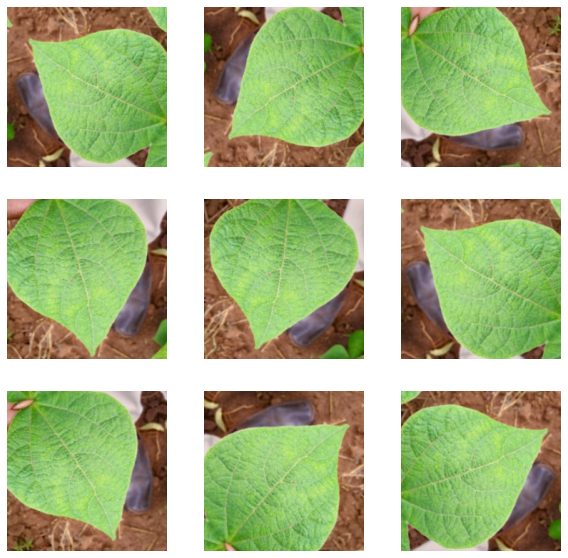

In [8]:
# DATA AUGMENTATION
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(
				height_factor=(-0.05, -0.15),
				width_factor=(-0.05, -0.15)),
])

#exemple
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
def VGG16(include_top=False, weights='imagenet',input_tensor=None,input_shape=None,pooling=False):
  # Not loaded the last two fully connected layers which act as the classifier. 
  # We are just loading the convolutional layers. Note: not specifying the shape of top layers, 
  # the input tensor shape is (None, None, 3),so you can use them for any size of images.
  model = tf.keras.applications.vgg16.VGG16(
                                            include_top=include_top,
                                            weights=weights,
                                            input_tensor=input_tensor,
                                            input_shape=input_shape,
                                            pooling=pooling)  
 
  return model

def show_result(acc, val_acc, loss, val_loss):
    plt.rcParams['axes.facecolor']='white'
    f, axarr = plt.subplots(1 , 2)
    f.set_figwidth(10)

    # Accuracy
    axarr[0].plot(acc)
    axarr[0].plot(val_acc)
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'valid'], loc='upper left')

    # Loss
    axarr[1].plot(loss)
    axarr[1].plot(val_loss)
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'valid'], loc='upper left')
    
    plt.show()

def Train(model, epochs, train_dataset, validation_dataset, test_dataset): 

      print('Start training')
      # define file name to save the model
      file_name = 'best_model.h5'
      # create checkpoint callbacks to save best model for the validation set
      checkpointer = tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_accuracy', verbose=10, save_best_only=True)
      # create early stopp callbacks to stop training after not imporvment
      early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, 
                                mode = 'max', patience = 15)
    
      # Make first evaluation
      loss0, accuracy0 = model.evaluate(validation_dataset)
      print("initial loss: {:.2f}".format(loss0))
      print("initial accuracy: {:.2f}".format(accuracy0))

      history = model.fit(train_dataset,
                          epochs=epochs,
                          validation_data=validation_dataset,
                          callbacks=[early_stop,checkpointer])

      
      show_result(history.history['accuracy'], 
                history.history['val_accuracy'],
                history.history['loss'],
                history.history['val_loss'])

      del model
      model = tf.keras.models.load_model(file_name)
      loss_val = model.evaluate(validation_dataset)
      loss_test = model.evaluate(test_dataset)
    
      print("[Validation loss: %f , Validation acc.:%.2f%%]" %(loss_val[0] , 100 * loss_val[1])) 
      print("[Test loss: %f , Test acc.:%.2f%%]" %(loss_test[0] , 100 * loss_test[1])) 

# Freeze only specific layers of the base model
def freeze_layer(net,freeze_lay_name):

  # Getting layer number through layer name
  for layer_number, layer in enumerate(net.layers):
    if layer.name == freeze_lay_name:
      lay_nb = layer_number
      break

  # Froze layers
  for layer in net.layers[:lay_nb]:
    layer.trainable = False

  return net


## 1. Training from scratch: 


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

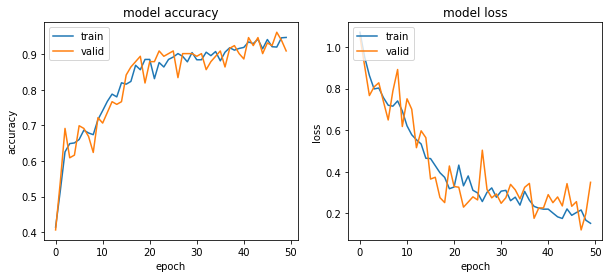

4/4 [==============================] - 1s 160ms/step - loss: 0.3013 - accuracy: 0.9062
[Validation loss: 0.120468 , Validation acc.:96.24%]
[Test loss: 0.301316 , Test acc.:90.62%]


In [11]:
base_model = VGG16(include_top=False, weights=None,input_shape=(224,224,3))
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
dense_1 = tf.keras.layers.Dense(64)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
# x = dense_1(x)

outputs = prediction_layer(x) # Add classification layer
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train and test
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

##  2 - Using a network pre-trained on ImageNet as a feature extractor

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

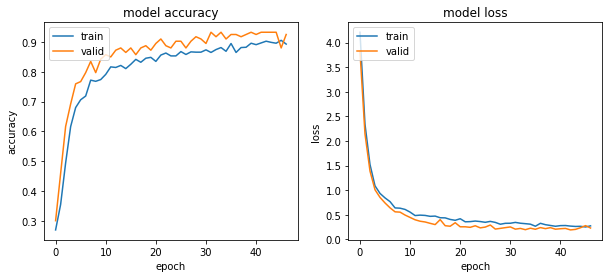

4/4 [==============================] - 1s 162ms/step - loss: 0.2673 - accuracy: 0.8984
[Validation loss: 0.205753 , Validation acc.:93.23%]
[Test loss: 0.267284 , Test acc.:89.84%]


In [12]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
base_model.trainable = False #freeze
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
dense_1 = tf.keras.layers.Dense(64)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
# x = dense_1(x)

outputs = prediction_layer(x) # Add classification layer
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train and test
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

## 3 - Taking a network pre-trained on ImageNet and fine-tuning the layers
#### a) Fine-tuning the latest layers

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

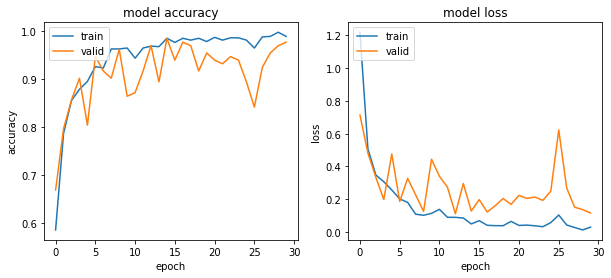

4/4 [==============================] - 1s 161ms/step - loss: 0.1066 - accuracy: 0.9531
[Validation loss: 0.127245 , Validation acc.:98.50%]
[Test loss: 0.106577 , Test acc.:95.31%]


In [ ]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
base_model = freeze_layer(base_model,'block5_conv1')
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
dense_1 = tf.keras.layers.Dense(64)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = dense_1(x)

outputs = prediction_layer(x) # Add classification layer
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train and test
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

#### b) Unfreeze the last convolutional blocks

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

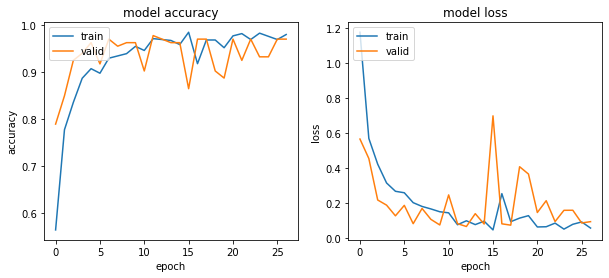

4/4 [==============================] - 1s 159ms/step - loss: 0.1767 - accuracy: 0.9375
[Validation loss: 0.082933 , Validation acc.:97.74%]
[Test loss: 0.176731 , Test acc.:93.75%]


In [ ]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
base_model = freeze_layer(base_model,'block4_conv1')
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
dense_1 = tf.keras.layers.Dense(64)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = dense_1(x)

outputs = prediction_layer(x) # Add classification layer
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train and test
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

#### c) Unfreeze all convolutional blocks

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

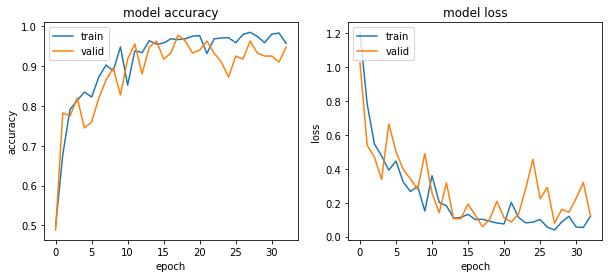

4/4 [==============================] - 1s 162ms/step - loss: 0.1423 - accuracy: 0.9375
[Validation loss: 0.058986 , Validation acc.:97.74%]
[Test loss: 0.142325 , Test acc.:93.75%]


In [ ]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
dense_1 = tf.keras.layers.Dense(64)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = dense_1(x)

outputs = prediction_layer(x) # Add classification layer
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train and test
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)